# Анализ данных сервиса проката самокатов GoFast

**Введение** В этом проекте по сервису аренды самокатов GoFast на основании предоставленных сведений о некоторых пользователях из нескольких городов, а также об их поездках сделана аналитика данных и проверка некоторыx гипотез, которые могут помочь бизнесу вырасти.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
from math import factorial
from math import sqrt
from scipy. stats import norm


#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscription = pd.read_csv('/datasets/subscriptions_go.csv')
print("таблица users")
display(users.head(5))
print()
print(users.info())
print()
print("таблица rides")
display(rides.head(5))
print()
print(rides.info())
print()
print("таблица subscription")
display(subscription.head(5))
print()
subscription.info()

таблица users


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None

таблица rides


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None

таблица subscription


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В загруженных данных есть информация о пользователях, их поездках и подписках.

#### Шаг 2. Предобработка данных

In [3]:
rides["date"] = pd.to_datetime(rides["date"], format ='%Y-%m-%d')
rides["month"] = rides["date"].dt.month
print(users.isna().sum())
print()
print(rides.isna().sum())
print()
subscription.isna().sum()



user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64



subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [4]:
print(rides["date"].min(),rides["date"].max())


2021-01-01 00:00:00 2021-12-30 00:00:00


Все даты принадлежат к одному году.

Пропусков данных не обнаружено.

In [5]:
print(users.duplicated().sum())
rides.duplicated().sum()

31


0

In [6]:
users = users.drop_duplicates()
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


In [7]:
users["city"].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Неявных дубликатов в названиях городов не обнаружено.

В ходе предобработки данных пропусков и неявных дубликатов данных не обнаружено, в таблице users обнаружены и удалены дубликаты, столбец date приведен к типу даты pandas, а таже проверено, что даты принадлежат к одному году,создан новый столбец с номером месяца на основе столбца date.

#### Шаг 3. Исследовательский анализ данных

Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: city, dtype: int64


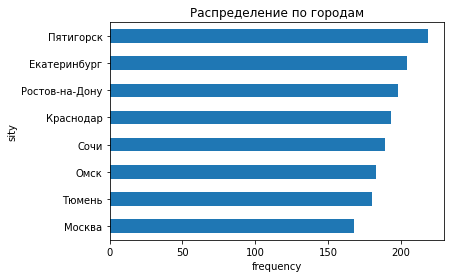

In [8]:
a = users["city"].value_counts(ascending = True)
print(a)
a.plot(kind="barh")
plt.xlabel("frequency")
plt.ylabel("sity")
plt.title("Распределение по городам")
plt.show()

Всех пользователей больше из Пятигорска, меньше всех в Москве.

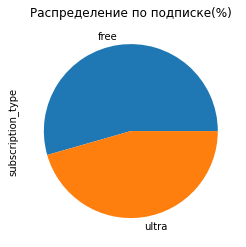

In [9]:
#users["subscription_type"].hist(bins=2)
a = users["subscription_type"].value_counts()
a.plot(kind="pie")
plt.title("Распределение по подписке(%)")
plt.show()

Пользователей без подписки больше, чем пользователей с подпиской.

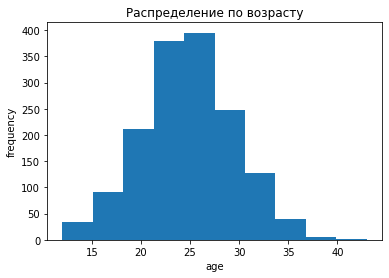

In [10]:
users["age"].plot(kind="hist",bins=10)
plt.ylabel("frequency")
plt.xlabel("age")
plt.title("Распределение по возрасту")
plt.show()


 Распределение пользователей по возрастам по графику близко к  нормальному, с пиком в 25 лет, в диапазоне от 12 до 47 лет.

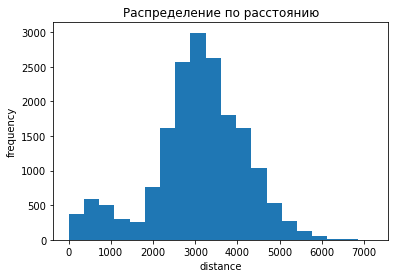

In [11]:
rides["distance"].plot(kind="hist",bins=20)
plt.ylabel("frequency")
plt.xlabel("distance")
plt.title("Распределение по расстоянию")
plt.show()

Самая частая дистанция одной поездки пользователя от 2900м до 3600м, сами дистанции в в диапазоне от 0м до 7100м.

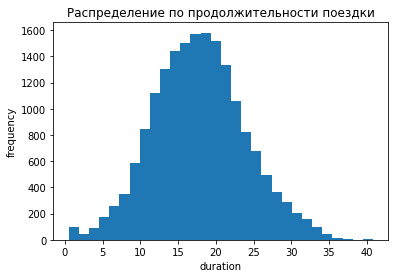

In [12]:
rides["duration"].plot(kind="hist",bins=30)
plt.ylabel("frequency")
plt.xlabel("duration")
plt.title("Распределение по продолжительности поездки")
plt.show()

Самая частая продолжительность поездки 17-20 минут, время поездок в диапазоне от 1 минуты до 40 минут

В ходе исследовательского анализа данных были выяснено, что всех пользователей больше из Пятигорска, меньше всех в Москве,пользователей без подписки больше, чем пользователей с подпиской,распределение пользователей по возрастам по графику близко к  нормальному, с пиком в 25 лет, в диапазоне от 12 до 47 лет,самая частая дистанция одной поездки пользователя от 2900м до 3600м, сами дистанции в в диапазоне от 0м до 7100м,самая частая продолжительность поездки 17-20 минут, время поездок в диапазоне от 1 минуты до 40 минут.

#### Шаг 4. Объединение данных

In [13]:
summary_zero = users.merge(rides,on ="user_id") #промежуточная таблица
summary = summary_zero.merge(subscription,on="subscription_type") #объединенная таблица
summary_ultra = summary.query("subscription_type == 'ultra'") #таблица пользователей с подпиской
summary_free = summary.query("subscription_type == 'free'") #таблица пользователей без подписки
print(summary.info())
                          

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB
None


Размер суммарной таблицы по количеству строк(18068) равен размеру таблицы rides по количеству строк(18068), что правильно, так как rides содержит информацию о поездках. 

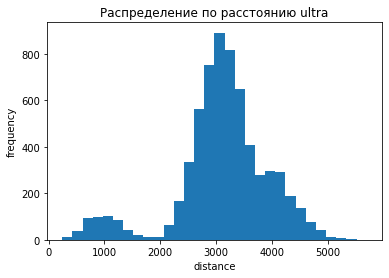

In [14]:
summary_ultra["distance"].plot(kind="hist",bins=30)
plt.ylabel("frequency")
plt.xlabel("distance")
plt.title("Распределение по расстоянию ultra")
plt.show() 

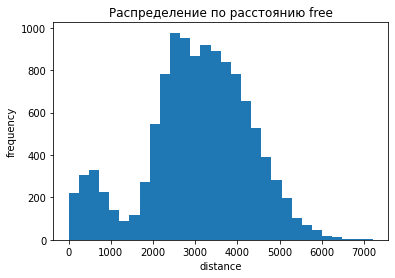

In [15]:
summary_free["distance"].plot(kind="hist",bins=30)
plt.ylabel("frequency")
plt.xlabel("distance")
plt.title("Распределение по расстоянию free")
plt.show()

Пик поездок пользователей по расстоянию у тех, кто с подпиской - более выражен(3000м-3300м), у тех, кто без подписки - более равномерно распределен(2100-3500м).

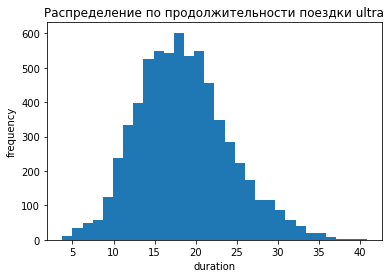

In [16]:
summary_ultra["duration"].plot(kind="hist",bins=30)
plt.ylabel("frequency")
plt.xlabel("duration")
plt.title("Распределение по продолжительности поездки ultra")
plt.show()

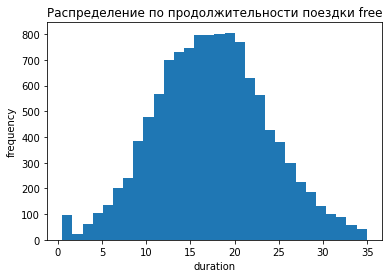

In [17]:
summary_free["duration"].plot(kind="hist",bins=30)
plt.ylabel("frequency")
plt.xlabel("duration")
plt.title("Распределение по продолжительности поездки free")
plt.show()

Сделаны объединенные таблицы и проверены на количество строк с исходными.Построены графики на основе таблиц с последующими выводами.
Пик поездок пользователей по расстоянию у тех, кто с подпиской - более выражен(3000м-3300м), у тех, кто без подписки - более равномерно распределен(2100-3500м).Пик поездок пользователей по времени у тех, кто с подпиской - более выражен(15 минут-17 минут), у тех, кто без подписки - более равномерно распределен(14 минут-20 минут).

#### Шаг 5. Подсчёт выручки

In [18]:
summary['duration'] = np.ceil(summary['duration'])
summary_agg = summary.groupby(['month','user_id']).aggregate({'user_id':'count','distance':'sum',
'duration':'sum','minute_price':'first','start_ride_price':'first','subscription_fee':'first'})

summary_agg['revenue'] = (summary_agg['user_id']*summary_agg['start_ride_price']+
summary_agg['minute_price']*summary_agg['duration']+summary_agg['subscription_fee'])
summary_agg = summary_agg.drop(['minute_price','start_ride_price'],axis ='columns')
summary_agg = summary_agg.rename(columns={'user_id':'ride_sum','distance':'distance_sum','duration':'duration_sum',})
summary_agg.head(5)

ride_sum  distance_sum  duration_sum  subscription_fee  revenue
month user_id                                                                 
1     1               2   7027.511294          42.0               199    451.0
      3               1   3061.777147          13.0               199    277.0
      5               1   3914.646990          13.0               199    277.0
      7               2   6478.080979          28.0               199    367.0
      12              1   3577.151148          33.0               199    397.0

Сделана сводная таблица для расчета выручки по месяцам по формуле : (стоимость старта поездки умножить на  количество поездок) плюс (стоимость одной минуты поездки умножить на общая продолжительность всех поездок в минутах) плюс стоимость подписки.

#### Шаг 6. Проверка гипотез

##### Гипотеза о "выгоде" пользователей с подпиской по количеству времени на поездки

Проверка гипотезы о том тратят ли пользователи с подпиской больше времени на поездки. Нулевая гипотеза, что количество времени одинаковое, альтернативная, что пользователи с подпиской тратят больше времени, чем пользователи без подписки. Для проверки гипотезы использование исходных данных о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

In [20]:
alpha = 0.05
results = st.ttest_ind(summary_ultra["duration"], summary_free["duration"],equal_var=False,alternative='greater' )
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


 Гипотеза(альтернативная) о "выгоде" пользователей с подпиской по количеству времени на поездки не отвергается.

##### Гипотеза о том,что расстояние одной поездки пользователей с подпиской не превышает 3130 метров

Расстояние одной поездки в 3130м метров — оптимальное с точки зрения износа самоката. Проверка гипотезы о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.Нулевая гипотеза, то что расстояние равно(не превышает) 3130 метров, альтернативная , что больше 3130 метров.

In [21]:
alpha = 0.05 
results = st.ttest_1samp(
    summary_ultra["distance"], 
    3130,
      alternative='greater')
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


 Гипотеза(нулевая) о том, что расстояние одной поездки пользователей не превышает 3130 метров не отвергается.

##### Гипотеза о том,что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Проверка гипотезы о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Нулевая гипотеза, что выручки пользователей с подпиской и без подписки равны, альтернативная, что выручка от пользователей по месяцам выше

In [22]:
alpha = 0.05
results = st.ttest_ind(summary_agg.loc[summary_agg["subscription_fee"] > 0]["revenue"],
                       summary_agg.loc[summary_agg["subscription_fee"] == 0]["revenue"],equal_var=False,alternative='greater' )
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    

p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


Гипотеза(альтернативная) о том,что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки не отвергается.

#####  Какой тест нужен для проверки гипотезы о снижении количества обращений в техподдержку после обновления серверов на основе файла с данными по каждому пользователю о количестве обращений до обновления и после него

Чтобы проверить эту гипотезу применим метод scipy.stats.ttest_rel().Ему достаточно передать всего два параметра: наборы данных до и после. Нулевая гипотеза - то, что количество обращений не изменится, альтернативная, то что изменится. Но при этом возможен вариант, когда количество обращений изменится, но в сторону увеличения... 


#### Шаг 7. Распределения

##### Задание о количестве промокодов

0.9502851068730583


<function matplotlib.pyplot.show(close=None, block=None)>

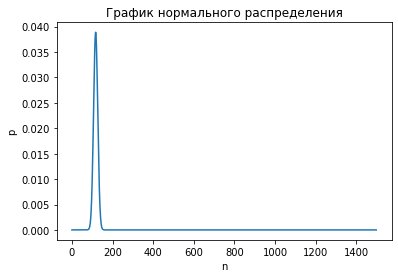

In [23]:
# задаём параметры биномиального распределения
n = 1169
p = 0.1

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста справа от 100 
result = 1 - distr.cdf(100)
print(result)

x = np.arange (0, 1500, 1) # задание оси x для графика нормального распределения
plt.plot (x, norm. pdf (x, mu, sigma))
plt.ylabel("p")
plt.xlabel("n")
plt.title("График нормального распределения")
plt.show

При p=0.01 и n>200 можно аппроксимировать биномиальное распределение нормальным. Подбором n находим значение количества промокодов равное 1169 , которые подходит к условию задачи(5% вероятность невыполнения плана или 95% вероятность выполнения)

##### Задание о push-уведомлениях

0.15371708296369768


<function matplotlib.pyplot.show(close=None, block=None)>

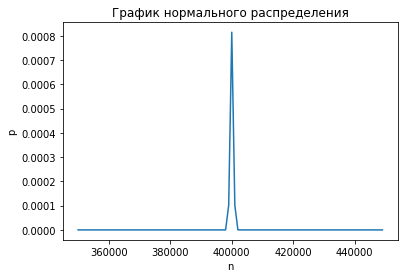

In [24]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399500 
result = distr.cdf(399500)
print(result)

x = np.arange (350000, 450000, 1000) # задание оси x для графика нормального распределения
plt.plot (x, norm. pdf (x, mu, sigma))
plt.ylabel("p")
plt.xlabel("n")
plt.title("График нормального распределения")
plt.show

При p=0.4 и большом количестве n можно аппроксимировать биномиальное распределение нормальным. Вероятность того, что того, что уведомление откроют не более 399,5 тысяч пользователей составляет 15,37%


**Итоговый вывод**
В ходе проекта было сделано нижеследующее.
1. Загружены данных с информация о пользователях, их поездках и подписках.
2. В ходе предобработки данных пропусков и неявных дубликатов данных не обнаружено, в таблице users обнаружены и удалены дубликаты, столбец date приведен к типу даты pandas, а таже проверено, что даты принадлежат к одному году,создан новый столбец с номером месяца на основе столбца date.
3. В ходе исследовательского анализа данных были выяснено, что пользователей больше всего из Пятигорска, меньше всех в Москве,пользователей без подписки больше, чем пользователей с подпиской,распределение пользователей по возрастам по графику близко к  нормальному, с пиком в 25 лет, в диапазоне от 12 до 47 лет,самая частая дистанция одной поездки пользователя от 2900м до 3600м, сами дистанции в в диапазоне от 0м до 7100м,самая частая продолжительность поездки 17-20 минут, время поездок в диапазоне от 1 минуты до 40 минут.
4. Сделаны объединенные таблицы и проверены на количество строк с исходными.Построены графики на основе таблиц с последующими выводами.
Пик поездок пользователей по расстоянию у тех, кто с подпиской - более выражен(3000м-3300м), у тех, кто без подписки - более равномерно распределен(2100-3500м).Пик поездок пользователей по времени у тех, кто с подпиской - более выражен(15 минут-17 минут), у тех, кто без подписки - более равномерно распределен(14 минут-20 минут).
5. Сделана сводная таблица для расчета выручки по месяцам
6. Произведена проверка гипотез, на их основе сделаны главные выводы.
7. Сделаны задания на распределения количества промокодов и  push-уведомлений.

Главные выводы.
1. Гипотеза о том, что расстояние одной поездки пользователей не превышает 3130 метров не отвергается. 
2. Гипотеза о "выгоде" пользователей с подпиской по количеству времени на поездки не отвергается.
3. Гипотеза о том,что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки не отвергается.
На основании проверки этих гипотез можно сделать вывод, что **пользователи с подпиской являются более выгодными для компании.**

Рекомендация.
 Уточнить критерии классификации по наличию подписки, если пользователь в течении месяца переходил из free в ultra и наоборот.